# Reinforcement Learning in Finite MDPs

In [1]:
!git clone https://github.com/rlgammazero/mvarl_hands_on.git > /dev/null 2>&1

## MDPs

In [26]:
import sys
sys.path.insert(0, './mvarl_hands_on/utils')
import numpy as np
from scipy.special import softmax # for SARSA
import matplotlib.pyplot as plt
import json
import math
import random
from copy import deepcopy
from cliffwalk import CliffWalk
from test_env import ToyEnv1

Setting up the environment

In [3]:
env = CliffWalk(proba_succ=0.98)

####################################################################################
# You probably want to test smaller enviroments before
# env = ToyEnv1(gamma=0.95)
####################################################################################

# Useful attributes
print("Set of states:", env.states)
print("Set of actions:", env.actions)
print("Number of states: ", env.Ns)
print("Number of actions: ", env.Na)
print("P has shape: ", env.P.shape)  # P[s, a, s'] = env.P[s, a, s']
print("discount factor: ", env.gamma)
print("")

# Usefult methods
state = env.reset() # get initial state
print("initial state: ", state)
print("reward at (s=1, a=3,s'=2): ", env.reward_func(1,3,2))
print("")

# A random policy
policy = np.random.randint(env.Na, size = (env.Ns,))
print("random policy = ", policy)

# Interacting with the environment
print("(s, a, s', r):")
for time in range(4):
    action = policy[state]
    next_state, reward, done, info = env.step(action)
    print(state, action, next_state, reward)
    if done:
        break
    state = next_state
print("")

Set of states: range(0, 48)
Set of actions: [0, 1, 2, 3]
Number of states:  48
Number of actions:  4
P has shape:  (48, 4, 48)
discount factor:  0.99

initial state:  36
reward at (s=1, a=3,s'=2):  0.6

random policy =  [3 1 3 3 3 0 3 2 2 1 1 0 0 1 0 2 2 0 0 1 3 2 0 0 0 3 3 3 0 0 3 3 1 1 1 2 0
 3 0 0 0 0 1 3 1 0 1 1]
(s, a, s', r):
36 0 37 0.6
37 3 25 0.0
25 3 13 0.6
13 1 25 0.6



## Question 1: Value iteration
1. Write a function applying the optimal Bellman operator on a provided Q function: $Q_1 = LQ_0, \; Q_0\in \mathbb{R}^{S\times A}$
2. Write a function implementing Value Iteration (VI) with $\infty$-norm stopping condition (reuse function implemented in 1)
3. Evaluate the convergence of your estimate, i.e., plot the value $\|Q_n - Q^\star\|_{\infty}$

In [21]:
# --------------
# Point 1
# --------------

def find_policy(Q):
    policy = list()
    for q in Q:
        policy.append(q.index(max(q)))
    return policy
    
def bellman_operator(Q0, Ns, Na, R, P, gamma):
    Q1 = [[0 for _ in range(Na)] for _ in range(Ns)] 
    for s1 in range(Ns):
        for a in range(Na):
            for s2 in range(Ns):
                Q1[s1][a] += P[s1,a,s2] * (R(s1,a,s2) + gamma * max(Q0[s2]))
    greedy_policy = find_policy(Q1)
    
    return Q1, greedy_policy

In [171]:
# --------------
# Point 2
# --------------

def max_err(Q1, Q2, env):
    max_err = -1
    for s in env.states:
        for a in env.actions:
            curr_err = abs(Q1[s][a] - Q2[s][a])
            if curr_err > max_err:
                max_err = curr_err
    return max_err


def value_iteration(Q0, env, epsilon=1e-5):
    
    Q_history = [Q0]
    
    S = env.states
    A = env.actions
    Ns = env.Ns
    Na = env.Na
    P = env.P 
    gamma = env.gamma
    
    R = env.reward_func
    
    Q1, greedy_policy = bellman_operator(Q0, Ns, Na, R, P, gamma)
    Q_history.append(Q1)
    
    while (max_err(Q_history[-1], Q_history[-2], env) > epsilon):
        #print(max_err(Q_history[-1], Q_history[-2], env))
        Q1, greedy_policy = bellman_operator(Q_history[-1], Ns, Na, R, P, gamma)
        Q_history.append(Q1)
    
    
    return Q1, greedy_policy, Q_history

Text(0.5, 1.0, 'Q-learning: Convergence of Q')

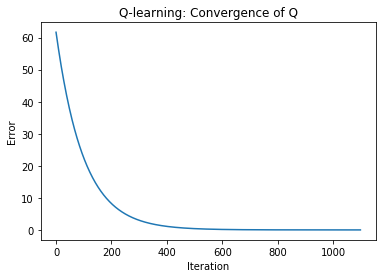

In [172]:
# --------------
# Point 3
# --------------
with open("./mvarl_hands_on/data/Q_opts.json", "r") as fp:
    Qopts = json.load(fp)
Qstar = Qopts["{}_{}".format(type(env).__name__,env.gamma)]

Q0 = [[1 for a in env.actions] for s in env.states]

Q, greedy_policy, Q_history = value_iteration(Q0, env)

norm_values = [max_err(q, Qstar, env) for q in Q_history]

plt.plot(norm_values)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title("Q-learning: Convergence of Q")

In [24]:
state = env.reset()
env.render()
for i in range(50):
    action = greedy_policy[state]
    state, reward, done, _ = env.step(action)
    env.render()

+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|_: : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (up)
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| :_: : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : :_: : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : :_: : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : :_: : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
+------

## Question 2: Q learning
Q learning is a model-free algorithm for estimating the optimal Q-function online.
It is an off-policy algorithm since the samples are collected with a policy that is (potentially) not the one associated to the estimated Q-function.

1. Implement Q learning with $\epsilon$-greedy exploration.
  - Plot the error in Q-functions over iterations
  - Plot the cumulative sum of rewards

In [153]:
# Use the previous code to verify the correctness of q learning
Q_opt, pi_opt, _ = value_iteration(Q0, env, epsilon=1e-8)

In [184]:
# ---------------------------
# Q-Learning
# ---------------------------
# suggested interface
# you can change it!
class QLearning:
    """
    Q learning with epsilon-greedy exploration
    """
    def __init__(self, eps, q, env):
        self.eps = eps
        self.q = q
        self.env = env
        self.visited = np.zeros((env.Ns, env.Na))
    
    def sample_action(self, state):
        prob = np.random.random()
        if prob <= 1-self.eps:
            return self.env.actions[np.random.randint(0, high=4)]
        else:
            return np.argmax(self.q[state])
    
    def update(self, state, action, next_state, reward):
        delta = reward + self.env.gamma * max(self.q[next_state]) - self.q[state][action]
        self.q[state][action] += 1/(self.f(state, action)**(1/2)) * delta
    
    def f(self, state, action):
        self.visited[state, action] +=1
        return self.visited[state, action]

+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|_: : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (left)
None
optimal policy:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0]
est policy: [0 0 0 1 2 0 0 0 0 0 1 1 1 2 1 2 2 0 1 1 1 0 0 1 1 2 2 2 0 0 0 0 2 0 0 1 2
 3 3 2 3 0 3 0 3 3 0 1]


Text(0.5, 1.0, 'Q-Learning: Rewards')

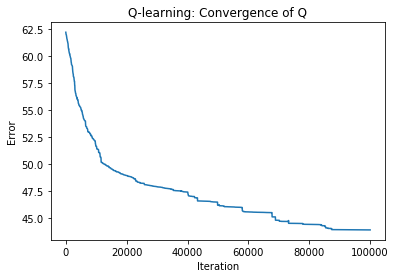

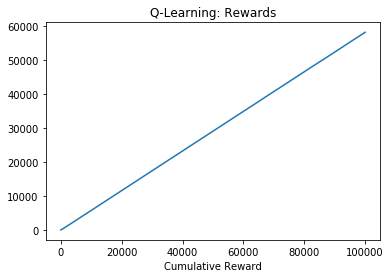

In [185]:
# --------------
# Point 1
# --------------
# Number of Q learning steps
max_steps = int(1e5)  
#max_steps = 10

Q0 = np.zeros((env.Ns, env.Na))
#Q0 = np.random.rand(env.Ns, env.Na)
eps = 0.9

ql = QLearning(eps, Q0, env)

# main algorithmic loop
reward_cum = np.zeros((max_steps))
prev_reward = 0
norm_values = []
t = 0
while t < max_steps:
    curr_state = env.state
    action = ql.sample_action(env.state)
    new_state, reward, done, info = env.step(action)
    
    reward_cum[t] = prev_reward + reward
    prev_reward = reward_cum[t]
    
    norm_values.append(np.abs(ql.q - Q_opt).mean())
    ql.update(curr_state, action, new_state, reward)
    
    t = t + 1
    
print(env.render())
print("optimal policy: ", pi_opt)
greedy_policy = np.argmax(ql.q, axis=1)
print("est policy:", greedy_policy)

plt.figure()
plt.plot(norm_values)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title("Q-learning: Convergence of Q")

plt.figure()
plt.plot(reward_cum)
plt.xlabel('Iterations')
plt.xlabel('Cumulative Reward')
plt.title('Q-Learning: Rewards')
# how confident are you in the performance of the algorithm? maybe a single run is not enough

### Comment on convergence

We have run the above algorithm 20 times. We noted that for every run the error always decreased towards similar error values. As such, it seems clear that Q-Learning is effectively conveging. 